
# Feature Extraction (Özellik Çıkarımı)
Ham veriden değişken özelliklik üretmek demektir.

1. Yapısal verilerden değişkenler türetmek : belirli yapıda olan mevcut değişkenler üzerinden veri türetmek 

2. Yapısal olmayan verilerden değişkenler türetmek : görüntü, ses, video, yazı gibi..


### Binary Features: Flag, Bool, True-False

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/titanic.csv")
df.head()

PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1      0            113803 53.100  C123        S
4            5         0       3                           Allen, Mr. William Henry    male 35.000      0      0            373450  8.050   NaN        S

In [4]:
df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')

In [5]:
df["NEW_CABIN_BOOL"].head()

0    0
1    1
2    0
3    1
4    0
Name: NEW_CABIN_BOOL, dtype: int64

In [6]:
df.groupby("NEW_CABIN_BOOL").agg({"Survived": "mean"})

Survived
NEW_CABIN_BOOL          
0                  0.300
1                  0.667

Normalde çöp olan kabin değeri bir anda anlamlı hale geldi. Kabin numarası olanların hayatta kalma oranı çok yüksek oldu.

In [7]:
from statsmodels.stats.proportion import proportions_ztest
#count : başarı sayısı, nobs : gözlem sayısı
test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].sum(),
                                             df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].shape[0],
                                            df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
# H0 Hipotezi: iki oran arasında farklılık yok der.
# pvalue değeri 0.05 den küçük olduğı için H0 hipotezi red edilir. Yani aralarında istatistiksel olarak
#anlamlı bir farklılık var gibi gözükmektedir. modelleme yapmadan tam anlamıyla göremem ama fikir vermesini 
#sağlayabilirim. Survived değişkeni NEW_CABIN_BOOL değişkeninden mi ortaya çıkmış bunu bilmiyorum. Çok değişkenli
#etkiyide incelemen gerekir.

Test Stat = 9.4597, p-value = 0.0000


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
#gemidekilerin akrabalıklarını inceleyen iki değişkeni inceliyoruz.
df.loc[((df['SibSp'] + df['Parch']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SibSp'] + df['Parch']) == 0), "NEW_IS_ALONE"] = "YES"

df.groupby("NEW_IS_ALONE").agg({"Survived": "mean"})

Survived
NEW_IS_ALONE          
NO               0.506
YES              0.304

In [9]:
test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].sum(),
                                             df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].shape[0],
                                            df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
# H0 Hipotezi: iki oran arasında farklılık yok der.
# pvalue değeri 0.05 den küçük olduğı için H0 hipotezi red edilir. Yani aralarında istatistiksel olarak
#anlamlı bir farklılık var gibi gözükmektedir.
#bu değişkenide göz ardı edemeyeceğin ortaya çıktı.

Test Stat = -6.0704, p-value = 0.0000


### Text'ler Üzerinden Özellik Türetmek

#### Letter Count

In [10]:
#bir değişkende kaç tane harf var ise onu sayar.
df["NEW_NAME_COUNT"] = df["Name"].str.len()

In [11]:
df["NEW_NAME_COUNT"].head()

0    23
1    51
2    22
3    44
4    24
Name: NEW_NAME_COUNT, dtype: int64

#### Word Count

In [12]:
#bir değişkende kaç tane kelime var ise onu sayar.
df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))

In [13]:
df.head()

PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked  NEW_CABIN_BOOL NEW_IS_ALONE  NEW_NAME_COUNT  NEW_NAME_WORD_COUNT
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S               0           NO              23                    4
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C               1           NO              51                    7
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S               0          YES              22                    3
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1      0            113803 53.100  C123        S               1           NO              44                    7
4            5         0       3                           Allen, Mr. William Henry    male 35.000      0      0            373450  8.050   NaN        S               0          YES              24                    4

#### Özel Yapıları Yakalamak

In [14]:
df["NEW_NAME_DR"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

df.groupby("NEW_NAME_DR").agg({"Survived": ["mean","count"]})

# olası tüm featureları çıkar modelleme basamağında değerlendirilir. Normalde meslek yok ama DR. unvanına sahipleri bir flagleyelim.
# mümkün olan az değişkenle yüksek başarılara erişmeye çalış.
# doktor olanların hayatta kalma oranları daha yüksek çıktı. Fakat sayısınada bakmayı unutma 10 tane imiş.
# Önemli mi değil mi yoruma açık olmakla birlikte en azından kayda değerdir, dursun diyoruz.

Survived      
                mean count
NEW_NAME_DR               
0              0.383   881
1              0.500    10

#### Regex ile Değişken Türetmek

In [15]:
df['NEW_TITLE'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df.head()

PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked  NEW_CABIN_BOOL NEW_IS_ALONE  NEW_NAME_COUNT  NEW_NAME_WORD_COUNT  NEW_NAME_DR NEW_TITLE
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S               0           NO              23                    4            0        Mr
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C               1           NO              51                    7            0       Mrs
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S               0          YES              22                    3            0      Miss
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1      0            113803 53.100  C123        S               1           NO              44                    7            0       Mrs
4            5         0       3                           Allen, Mr. William Henry    male 35.000      0      0            373450  8.050   NaN        S               0          YES              24                    4            0        Mr

In [16]:
df[["NEW_TITLE", "Survived", "Age"]].groupby(["NEW_TITLE"]).agg({"Survived": "mean", "Age": ["count", "mean"]})

Survived   Age       
              mean count   mean
NEW_TITLE                      
Capt         0.000     1 70.000
Col          0.500     2 58.000
Countess     1.000     1 33.000
Don          0.000     1 40.000
Dr           0.429     6 42.000
Jonkheer     0.000     1 38.000
Lady         1.000     1 48.000
Major        0.500     2 48.500
Master       0.575    36  4.574
Miss         0.698   146 21.774
Mlle         1.000     2 24.000
Mme          1.000     1 24.000
Mr           0.157   398 32.368
Mrs          0.792   108 35.898
Ms           1.000     1 28.000
Rev          0.000     6 43.167
Sir          1.000     1 49.000

### Date Değişkenleri Üretmek

In [17]:
df = pd.read_csv("/content/gdrive/My Drive/course_reviews.csv")
df.head()

# Bir kursa yapılan puanlamalar var. Amacımız timestamp değişkeninden yeni değişkenler üretmek.

Rating            Timestamp             Enrolled  Progress  Questions Asked  Questions Answered
0   5.000  2021-02-05 07:45:55  2021-01-25 15:12:08     5.000            0.000               0.000
1   5.000  2021-02-04 21:05:32  2021-02-04 20:43:40     1.000            0.000               0.000
2   4.500  2021-02-04 20:34:03  2019-07-04 23:23:27     1.000            0.000               0.000
3   5.000  2021-02-04 16:56:28  2021-02-04 14:41:29    10.000            0.000               0.000
4   4.000  2021-02-04 15:00:24  2020-10-13 03:10:07    10.000            0.000               0.000

In [18]:
df.info()
#Timestamp object olduğu içi ilk önce bunu dönüştür.          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rating              4323 non-null   float64
 1   Timestamp           4323 non-null   object 
 2   Enrolled            4323 non-null   object 
 3   Progress            4323 non-null   float64
 4   Questions Asked     4323 non-null   float64
 5   Questions Answered  4323 non-null   float64
dtypes: float64(4), object(2)
memory usage: 202.8+ KB


In [19]:
df['Timestamp'] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d")

In [20]:
df.info()
 # dönüştürülmüş hali (from object to datetime64[ns])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Rating              4323 non-null   float64       
 1   Timestamp           4323 non-null   datetime64[ns]
 2   Enrolled            4323 non-null   object        
 3   Progress            4323 non-null   float64       
 4   Questions Asked     4323 non-null   float64       
 5   Questions Answered  4323 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 202.8+ KB


In [21]:
# year
df['year'] = df['Timestamp'].dt.year

In [22]:
# month
df['month'] = df['Timestamp'].dt.month

In [23]:
# year diff
df['year_dif'] = date.today().year - df['Timestamp'].dt.year

In [24]:
# month diff (iki tarih arasındaki ay farkı): yıl farkı + ay farkı
df['month_dif'] = (date.today().year - df['Timestamp'].dt.year) * 12 + date.today().month - df['Timestamp'].dt.month

In [25]:
# day name
df['day_name'] = df['Timestamp'].dt.day_name()

In [26]:
df.head()

Rating           Timestamp             Enrolled  Progress  Questions Asked  Questions Answered  year  month  year_dif  month_dif  day_name
0   5.000 2021-02-05 07:45:55  2021-01-25 15:12:08     5.000            0.000               0.000  2021      2         1         17    Friday
1   5.000 2021-02-04 21:05:32  2021-02-04 20:43:40     1.000            0.000               0.000  2021      2         1         17  Thursday
2   4.500 2021-02-04 20:34:03  2019-07-04 23:23:27     1.000            0.000               0.000  2021      2         1         17  Thursday
3   5.000 2021-02-04 16:56:28  2021-02-04 14:41:29    10.000            0.000               0.000  2021      2         1         17  Thursday
4   4.000 2021-02-04 15:00:24  2020-10-13 03:10:07    10.000            0.000               0.000  2021      2         1         17  Thursday

### Feature Interactions (Özellik Etkileşimleri)

In [27]:
df = pd.read_csv("/content/gdrive/My Drive/titanic.csv")
df.head()

PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1      0            113803 53.100  C123        S
4            5         0       3                           Allen, Mr. William Henry    male 35.000      0      0            373450  8.050   NaN        S

In [28]:
df["NEW_AGE_PCLASS"] = df["Age"] * df["Pclass"]

In [29]:
df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1

In [30]:
df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'

df.loc[(df['Sex'] == 'male') & (df['Age'] > 21) & (df['Age'] < 50), 'NEW_SEX_CAT'] = 'maturemale'

df.loc[(df['Sex'] == 'male') & (df['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'

df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'

df.loc[(df['Sex'] == 'female') & (df['Age'] > 21) & (df['Age'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'

df.loc[(df['Sex'] == 'female') & (df['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [31]:
df.head()

PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked  NEW_AGE_PCLASS  NEW_FAMILY_SIZE   NEW_SEX_CAT
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S          66.000                2    maturemale
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C          38.000                2  maturefemale
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S          78.000                1  maturefemale
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1      0            113803 53.100  C123        S          35.000                2  maturefemale
4            5         0       3                           Allen, Mr. William Henry    male 35.000      0      0            373450  8.050   NaN        S         105.000                1    maturemale

In [32]:
df.groupby("NEW_SEX_CAT")["Survived"].mean()

NEW_SEX_CAT
maturefemale   0.774
maturemale     0.199
seniorfemale   0.909
seniormale     0.135
youngfemale    0.679
youngmale      0.250
Name: Survived, dtype: float64

# Titanic Uçtan Uca Feature Engineering & Data Preprocessing (UYGULAMA)

In [33]:
df = pd.read_csv("/content/gdrive/My Drive/titanic.csv")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [35]:
df.columns = [col.upper() for col in df.columns]

In [36]:
df.head()

PASSENGERID  SURVIVED  PCLASS                                               NAME     SEX    AGE  SIBSP  PARCH            TICKET   FARE CABIN EMBARKED
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1      0            113803 53.100  C123        S
4            5         0       3                           Allen, Mr. William Henry    male 35.000      0      0            373450  8.050   NaN        S

## 1. Feature Engineering (Değişken Mühendisliği)

In [37]:
# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

df.head()


PASSENGERID  SURVIVED  PCLASS                                               NAME     SEX    AGE  SIBSP  PARCH            TICKET   FARE CABIN EMBARKED  NEW_CABIN_BOOL  NEW_NAME_COUNT  NEW_NAME_WORD_COUNT  NEW_NAME_DR NEW_TITLE  NEW_FAMILY_SIZE  NEW_AGE_PCLASS NEW_IS_ALONE NEW_AGE_CAT   NEW_SEX_CAT
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S               0              23                    4            0        Mr                2          66.000           NO      mature    maturemale
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C               1              51                    7            0       Mrs                2          38.000           NO      mature  maturefemale
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S               0              22                    3            0      Miss                1          78.000          YES      mature  maturefemale
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1      0            113803 53.100  C123        S               1              44                    7            0       Mrs                2          35.000           NO      mature  maturefemale
4            5         0       3                           Allen, Mr. William Henry    male 35.000      0      0            373450  8.050   NaN        S               0              24                    4            0        Mr                1         105.000          YES      mature    maturemale

In [38]:
df.shape

(891, 22)

In [39]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [40]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [41]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [42]:
df.shape

(891, 22)

In [43]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [44]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [45]:
cat_cols

['SEX',
 'EMBARKED',
 'NEW_TITLE',
 'NEW_IS_ALONE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT',
 'SURVIVED',
 'PCLASS',
 'SIBSP',
 'PARCH',
 'NEW_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE']

In [46]:
cat_but_car

['NAME', 'TICKET', 'CABIN']

## 2. Outliers (Aykırı Değerler)

In [47]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [48]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [49]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [50]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


## 3. Missing Values (Eksik Değerler)

In [51]:
na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


In [52]:
df.drop('CABIN', inplace=True, axis=1)

In [53]:
remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=True, axis=1)

In [54]:
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [55]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [56]:
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'


In [57]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [58]:
missing_values_table(df)

#eksik değer probleminden kurtulduk fakat kurtulmamayıda tercih edebilirdin. 

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## 4. Label Encoding

In [59]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [60]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
binary_cols

['SEX', 'NEW_IS_ALONE']

In [61]:
for col in binary_cols:
    df = label_encoder(df, col)

df.head()

PASSENGERID  SURVIVED  PCLASS  SEX    AGE  SIBSP  PARCH   FARE EMBARKED  NEW_CABIN_BOOL  NEW_NAME_COUNT  NEW_NAME_WORD_COUNT  NEW_NAME_DR NEW_TITLE  NEW_FAMILY_SIZE  NEW_AGE_PCLASS  NEW_IS_ALONE NEW_AGE_CAT   NEW_SEX_CAT
0            1         0       3    1 22.000      1      0  7.250        S               0              23                    4            0        Mr                2          66.000             0      mature    maturemale
1            2         1       1    0 38.000      1      0 65.634        C               1              45                    7            0       Mrs                2          38.000             0      mature  maturefemale
2            3         1       3    0 26.000      0      0  7.925        S               0              22                    3            0      Miss                1          78.000             1      mature  maturefemale
3            4         1       1    0 35.000      1      0 53.100        S               1              44                    7            0       Mrs                2          35.000             0      mature  maturefemale
4            5         0       3    1 35.000      0      0  8.050        S               0              24                    4            0        Mr                1         105.000             1      mature    maturemale

## 5. Rare Encoding

In [62]:
def rare_analyser(dataframe, survived, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "SURVIVED_MEAN": dataframe.groupby(col)[survived].mean()}), end="\n\n\n")

rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
   COUNT  RATIO  SURVIVED_MEAN
0    314  0.352          0.742
1    577  0.648          0.189


EMBARKED : 3
   COUNT  RATIO  SURVIVED_MEAN
C    168  0.189          0.554
Q     77  0.086          0.390
S    646  0.725          0.339


NEW_TITLE : 17
          COUNT  RATIO  SURVIVED_MEAN
Capt          1  0.001          0.000
Col           2  0.002          0.500
Countess      1  0.001          1.000
Don           1  0.001          0.000
Dr            7  0.008          0.429
Jonkheer      1  0.001          0.000
Lady          1  0.001          1.000
Major         2  0.002          0.500
Master       40  0.045          0.575
Miss        182  0.204          0.698
Mlle          2  0.002          1.000
Mme           1  0.001          1.000
Mr          517  0.580          0.157
Mrs         125  0.140          0.792
Ms            1  0.001          1.000
Rev           6  0.007          0.000
Sir           1  0.001          1.000


NEW_IS_ALONE : 2
   COUNT  RATIO  SURVIVED_MEAN
0    354 

In [63]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

    
df = rare_encoder(df, 0.01)

df["NEW_TITLE"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: NEW_TITLE, dtype: int64

## 6. One-Hot Encoding

In [64]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
# cat_cols, num_cols, cat_but_car = grab_col_names(df)

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols #özel şartlardaki kolonlar üzerinde get dummies yapmak için kullan. 

['PCLASS',
 'SIBSP',
 'PARCH',
 'EMBARKED',
 'NEW_NAME_WORD_COUNT',
 'NEW_TITLE',
 'NEW_FAMILY_SIZE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT']

In [65]:
df = one_hot_encoder(df, ohe_cols)

In [66]:
df.head()

PASSENGERID  SURVIVED  SEX    AGE   FARE  NEW_CABIN_BOOL  NEW_NAME_COUNT  NEW_NAME_DR  NEW_AGE_PCLASS  NEW_IS_ALONE  PCLASS_2  PCLASS_3  SIBSP_1  SIBSP_2  SIBSP_3  SIBSP_4  SIBSP_5  SIBSP_8  PARCH_1  PARCH_2  PARCH_3  PARCH_4  PARCH_5  PARCH_6  EMBARKED_Q  EMBARKED_S  NEW_NAME_WORD_COUNT_4  NEW_NAME_WORD_COUNT_5  NEW_NAME_WORD_COUNT_6  NEW_NAME_WORD_COUNT_7  NEW_NAME_WORD_COUNT_8  NEW_NAME_WORD_COUNT_9  NEW_NAME_WORD_COUNT_14  NEW_TITLE_Miss  NEW_TITLE_Mr  NEW_TITLE_Mrs  NEW_TITLE_Rare  \
0            1         0    1 22.000  7.250               0              23            0          66.000             0         0         1        1        0        0        0        0        0        0        0        0        0        0        0           0           1                      1                      0                      0                      0                      0                      0                       0               0             1              0               0   
1            2         1    0 38.000 65.634               1              45            0          38.000             0         0         0        1        0        0        0        0        0        0        0        0        0        0        0           0           0                      0                      0                      0                      1                      0                      0                       0               0             0              1               0   
2            3         1    0 26.000  7.925               0              22            0          78.000             1         0         1        0        0        0        0        0        0        0        0        0        0        0        0           0           1                      0                      0                      0                      0                      0                      0                       0               1             0              0               0   
3            4         1    0 35.000 53.100               1              44            0          35.000             0         0         0        1        0        0        0        0        0        0        0        0        0        0        0           0           1                      0                      0                      0                      1                      0                      0                       0               0             0              1               0   
4            5         0    1 35.000  8.050               0              24            0         105.000             1         0         1        0        0        0        0        0        0        0        0        0        0        0        0           0           1                      1                      0                      0                      0                      0                      0                       0               0             1              0               0   

   NEW_FAMILY_SIZE_2  NEW_FAMILY_SIZE_3  NEW_FAMILY_SIZE_4  NEW_FAMILY_SIZE_5  NEW_FAMILY_SIZE_6  NEW_FAMILY_SIZE_7  NEW_FAMILY_SIZE_8  NEW_FAMILY_SIZE_11  NEW_AGE_CAT_senior  NEW_AGE_CAT_young  NEW_SEX_CAT_maturemale  NEW_SEX_CAT_seniorfemale  NEW_SEX_CAT_seniormale  NEW_SEX_CAT_youngfemale  NEW_SEX_CAT_youngmale  
0                  1                  0                  0                  0                  0                  0                  0                   0                   0                  0                       1                         0                       0                        0                      0  
1                  1                  0                  0                  0                  0                  0                  0                   0                   0                  0                       0                         0                       0                        0                      0  
2                  0                  0                  0        

In [67]:
df.shape

(891, 52)

In [68]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47


In [69]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [70]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
   COUNT  RATIO  SURVIVED_MEAN
0    549  0.616          0.000
1    342  0.384          1.000


SEX : 2
   COUNT  RATIO  SURVIVED_MEAN
0    314  0.352          0.742
1    577  0.648          0.189


NEW_CABIN_BOOL : 2
   COUNT  RATIO  SURVIVED_MEAN
0    687  0.771          0.300
1    204  0.229          0.667


NEW_NAME_DR : 2
   COUNT  RATIO  SURVIVED_MEAN
0    881  0.989          0.383
1     10  0.011          0.500


NEW_IS_ALONE : 2
   COUNT  RATIO  SURVIVED_MEAN
0    354  0.397          0.506
1    537  0.603          0.304


PCLASS_2 : 2
   COUNT  RATIO  SURVIVED_MEAN
0    707  0.793          0.361
1    184  0.207          0.473


PCLASS_3 : 2
   COUNT  RATIO  SURVIVED_MEAN
0    400  0.449          0.557
1    491  0.551          0.242


SIBSP_1 : 2
   COUNT  RATIO  SURVIVED_MEAN
0    682  0.765          0.337
1    209  0.235          0.536


SIBSP_2 : 2
   COUNT  RATIO  SURVIVED_MEAN
0    863  0.969          0.381
1     28  0.031          0.464


SIBSP_3 : 2
   COUNT  

In [71]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
useless_cols 
# df.drop(useless_cols, axis=1, inplace=True) ile silmek istersen bu kolonları silebilirsin

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

## 7. Standart Scaler

In [72]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

AGE   FARE  NEW_NAME_COUNT  NEW_AGE_PCLASS
0 -0.561 -0.821          -0.437           0.066
1  0.663  2.032           2.248          -0.790
2 -0.255 -0.788          -0.559           0.434
3  0.434  1.419           2.126          -0.882
4  0.434 -0.781          -0.315           1.260

In [73]:
print(df.head())
print(df.shape)

   PASSENGERID  SURVIVED  SEX    AGE   FARE  NEW_CABIN_BOOL  NEW_NAME_COUNT  NEW_NAME_DR  NEW_AGE_PCLASS  NEW_IS_ALONE  PCLASS_2  PCLASS_3  SIBSP_1  SIBSP_2  SIBSP_3  SIBSP_4  SIBSP_5  SIBSP_8  PARCH_1  PARCH_2  PARCH_3  PARCH_4  PARCH_5  PARCH_6  EMBARKED_Q  EMBARKED_S  NEW_NAME_WORD_COUNT_4  NEW_NAME_WORD_COUNT_5  NEW_NAME_WORD_COUNT_6  NEW_NAME_WORD_COUNT_7  NEW_NAME_WORD_COUNT_8  NEW_NAME_WORD_COUNT_9  NEW_NAME_WORD_COUNT_14  NEW_TITLE_Miss  NEW_TITLE_Mr  NEW_TITLE_Mrs  NEW_TITLE_Rare  \
0            1         0    1 -0.561 -0.821               0          -0.437            0           0.066             0         0         1        1        0        0        0        0        0        0        0        0        0        0        0           0           1                      1                      0                      0                      0                      0                      0                       0               0             1              0               0   
1     

## 8. Model

In [74]:
y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [77]:
accuracy_score(y_pred, y_test)

0.8059701492537313

## Yeni ürettiğimiz değişkenler ne alemde?

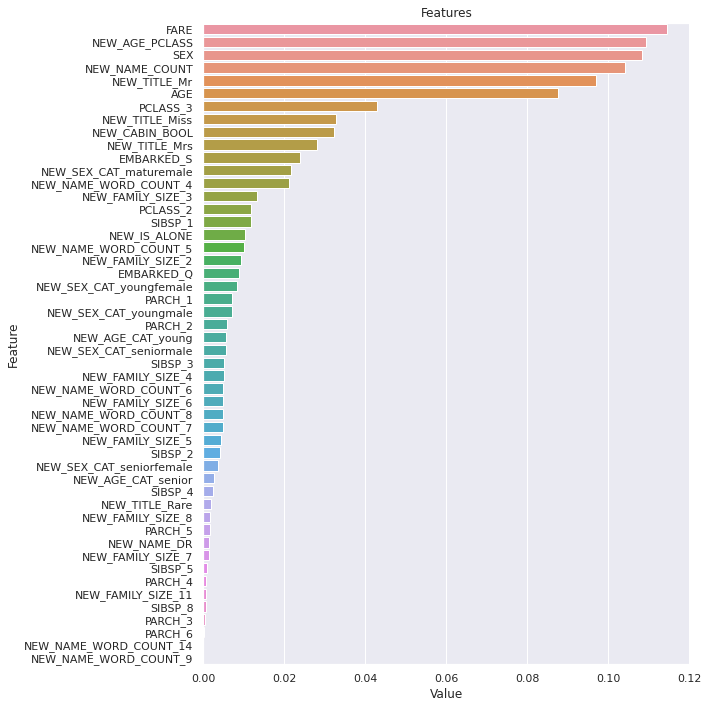

In [78]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

## Hiç bir işlem yapılmadan elde edilecek skor?


In [79]:
dff = pd.read_csv("/content/gdrive/My Drive/titanic.csv")
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7090909090909091